### Pix2Pix Model for satelite images

#### Importing libraries and setting up device

In [1]:
# Importing libraries
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from datetime import datetime
from keras.utils import img_to_array, load_img
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import  Model
from keras.layers import  Input, Conv2D, Conv2DTranspose, Concatenate, Activation, LeakyReLU, BatchNormalization, Dropout
from keras.models import load_model
from keras.utils import plot_model


print(f'Available Device: {tf.config.list_physical_devices("GPU")}')

Available Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Discriminator architecture

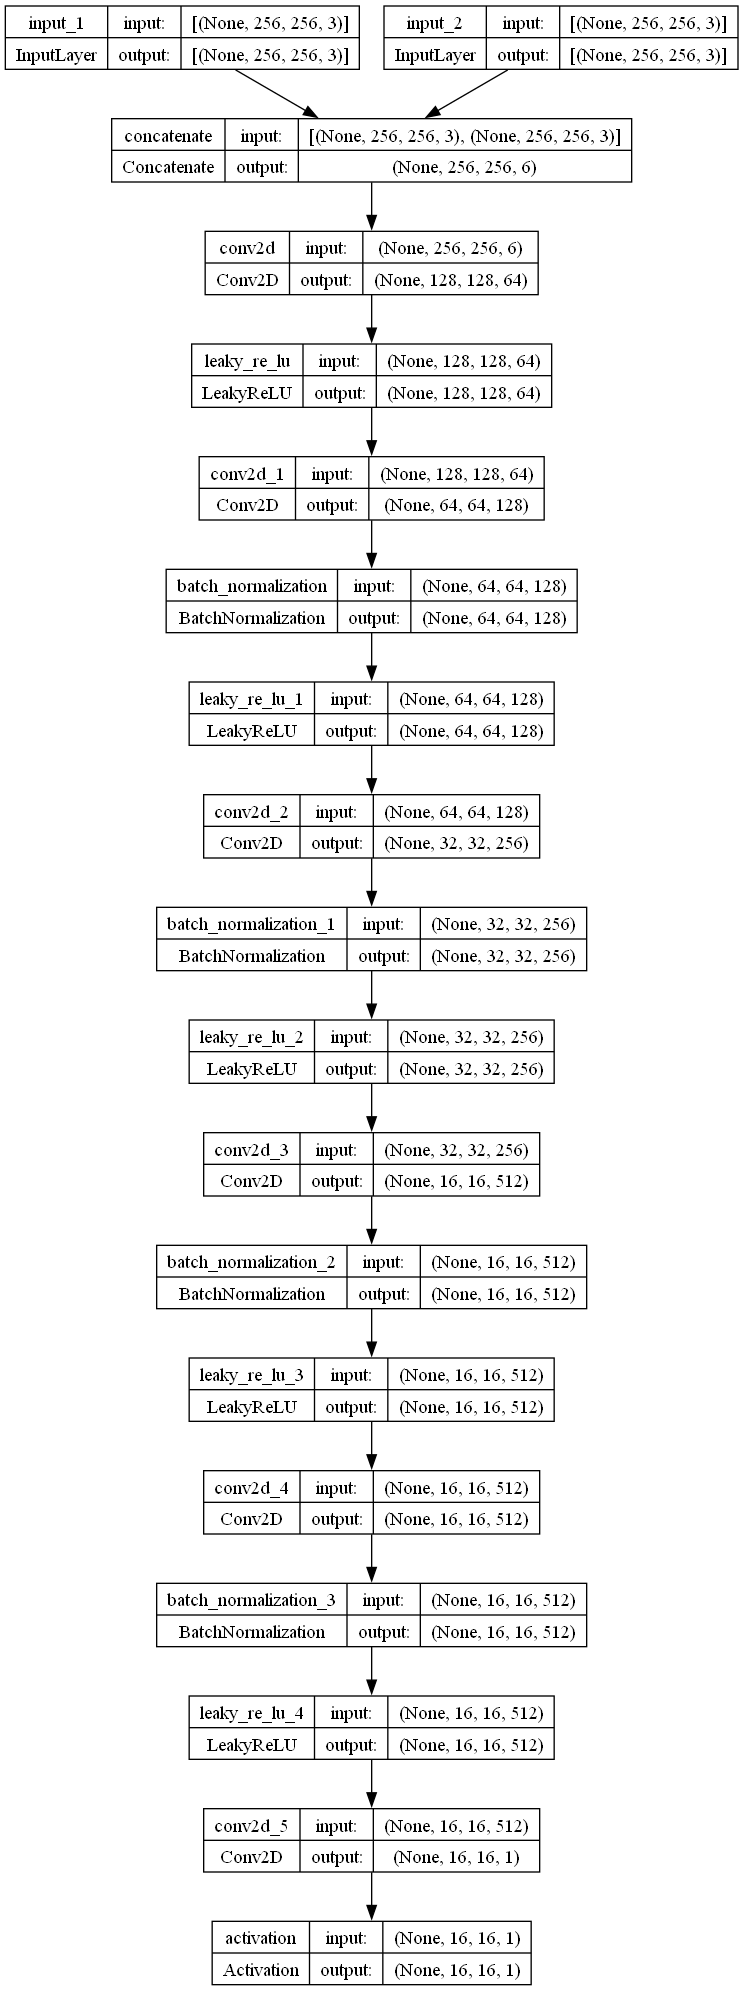

In [2]:
def Discriminator(image_shape):
    
    # creating weight initializer
    init = RandomNormal(stddev = 0.02, seed=0)
    
    # source image layer
    in_src_shape = Input(shape = image_shape)
    
    # target image layer
    target_src_layer = Input(shape = image_shape)
    
    # concatenated image layer
    merged_layer = Concatenate()([in_src_shape, target_src_layer])
    
    # first conv block without batchnorm
    dis = Conv2D(64, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = init)(merged_layer)
    dis = LeakyReLU(alpha = 0.2)(dis)
    
    # second conv block with batchnorm
    dis = Conv2D(128, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = init)(dis)
    dis = BatchNormalization()(dis)
    dis = LeakyReLU(alpha = 0.2)(dis)
    
    # third conv block with batchnorm
    dis = Conv2D(256, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = init)(dis)
    dis = BatchNormalization()(dis)
    dis = LeakyReLU(alpha = 0.2)(dis)
    
    #  fourth conv block with batchnorm
    dis = Conv2D(512, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = init)(dis)
    dis = BatchNormalization()(dis)
    dis = LeakyReLU(alpha = 0.2)(dis)
    
    # fifth conv block with batchnorm
    dis = Conv2D(512, kernel_size = (4,4), padding = 'same', kernel_initializer = init)(dis)
    dis = BatchNormalization()(dis)
    dis = LeakyReLU(alpha = 0.2)(dis)
    
    # sixth conv block with batchnorm
    dis = Conv2D(1, kernel_size = (4,4), padding = 'same', kernel_initializer = init)(dis)
    out = Activation(activation = 'sigmoid')(dis)
    
    # creating a model based on all layers
    model = Model([in_src_shape, target_src_layer], out)
    
    # compiling the model
    optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', loss_weights = [0.5])
    
    return model


disc_model = Discriminator((256,256,3))
plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

#### Generator U-net architecture

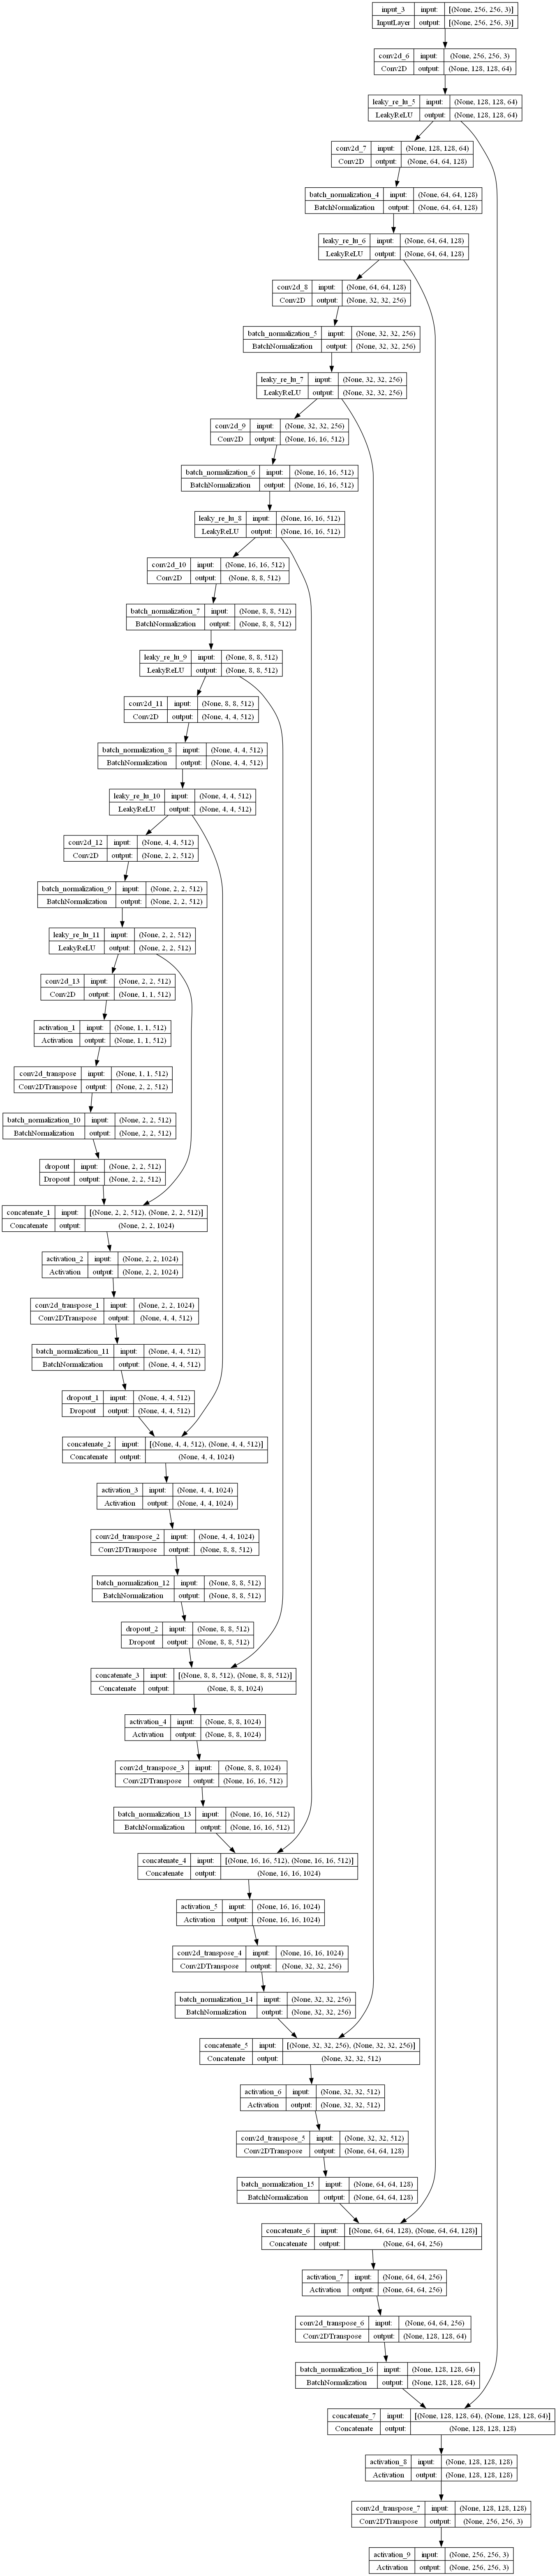

In [4]:
# Creating a encoder block
def encoder_block(input_layer, n_filters, batch_norm = True):
    
    # initializing weights
    init = RandomNormal(stddev = 0.02, seed = 0)
    
    # conv layer 
    g = Conv2D(n_filters, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = init)(input_layer)
    
    # if batch_norm is true
    if batch_norm:
        g = BatchNormalization()(g, training = True)
        
    # leaky relu activation
    g = LeakyReLU(alpha = 0.2)(g)
    
    return g

# creating a decoder block
def decoder_block(n_filters, skip_con, input_layer, dropout = True):
    
    # initializing weights
    init = RandomNormal(stddev = 0.02, seed = 0)
    
    # conv layer 
    g = Conv2DTranspose(n_filters, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = init)(input_layer)
    
    # adding batch norm
    g = BatchNormalization()(g, training = True)
    
    # adding dropout layer
    if dropout:
        g = Dropout(0.5)(g, training = True)
        
    # merging with previous encoder skip connection block
    g = Concatenate()([g, skip_con])
    
    # Activation layer for concatenated layer
    g = Activation(activation = 'relu')(g)
    
    return g

# creating final generator architecture
def Generator(image_shape=(256,256,3)):
    # initializing weights
    init = RandomNormal(stddev=0.02, seed = 0)
    
    # input layer image 
    in_src_image = Input(shape=image_shape)
    
    # U-net encoder blocks
    up1 = encoder_block(in_src_image, 64, batch_norm=False)  # 256x256 -> 128x128
    up2 = encoder_block(up1, 128)  # 128x128 -> 64x64
    up3 = encoder_block(up2, 256)  # 64x64 -> 32x32
    up4 = encoder_block(up3, 512)  # 32x32 -> 16x16
    up5 = encoder_block(up4, 512)  # 16x16 -> 8x8
    up6 = encoder_block(up5, 512)  # 8x8 -> 4x4
    up7 = encoder_block(up6, 512)  # 4x4 -> 2x2
    
    # bottleneck layer
    bottleneck_layer = Conv2D(512, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(up7)  # 2x2 -> 1x1
    b_activation = Activation(activation='relu')(bottleneck_layer)
    
    # U-net decoder blocks (matching the encoder steps in reverse)
    down1 = decoder_block(512, up7, b_activation)  # 1x1 -> 2x2
    down2 = decoder_block(512, up6, down1)  # 2x2 -> 4x4
    down3 = decoder_block(512, up5, down2)  # 4x4 -> 8x8
    down4 = decoder_block(512, up4, down3, dropout=False)  # 8x8 -> 16x16
    down5 = decoder_block(256, up3, down4, dropout=False)  # 16x16 -> 32x32
    down6 = decoder_block(128, up2, down5, dropout=False)  # 32x32 -> 64x64
    down7 = decoder_block(64, up1, down6, dropout=False)  # 64x64 -> 128x128
    
    # end layer for -1 to +1 value
    last_conv = Conv2DTranspose(image_shape[2], kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer = init)(down7)  # 128x128 -> 256x256
    last_layer = Activation(activation = 'tanh')(last_conv)
    
    # creating model
    model = Model(in_src_image, last_layer)

    return model

gen_model = Generator((256,256,3))
plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

#### Final GAN architecture with Generator and Discriminator

In [5]:
# combining both generator and discriminator into one model
def Pix2PixModel(generator, discriminator, image_shape):
    
    # discriminator is trainable only when its standalone, for each batch of generator, it is untrainable
    for layer in discriminator.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
            
    # input source image layer
    in_src_image = Input(shape = image_shape)
    
    # generator input image as input
    gene_out = generator(in_src_image)
    
    # discriminator input image and gene_out as input
    dis_out = discriminator([in_src_image, gene_out])
    
    # final GAN compilation
    model = Model(in_src_image, [dis_out, gene_out]) 
    
    # optimizer for final GAN
    optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5)
    
    # model compilation
    model.compile(optimizer = optimizer, loss = ['binary_crossentropy', 'mae'], loss_weights = [1, 100])
    
    return model

#### Generating real and fake samples

In [8]:
# fetching real data from dataset and creating labels
def generate_real_sample(datasets, n_samples, patch_shape):
    
    # getting two separate image for training
    trainA, trainB = datasets
    
    # random indices for choosing images
    idx = np.random.randint(0, trainA.shape[0], n_samples)
    
    # picking the same image from random indices
    X1, X2 = trainA[idx], trainB[idx]
    
    # creating labels for two sets of images
    y = np.ones(shape = (n_samples, patch_shape, patch_shape, 1))
    
    return [X1, X2], y

# creating fake data from generator and creating labels
def generate_fake_sample(generator, samples, patch_shape):
    
    # creating fake images
    X = generator.predict(samples)
    
    # creating fake labels for fake data
    y = np.zeros(shape = (len(X), patch_shape, patch_shape, 1))
    
    return X, y

# summarzing performance based on the generated images
def summarize_performance(step, generator, dataset, n_samples = 3):
    
    # extracting sample data and generating fake data
    [X_realA, X_realB], _ = generate_real_sample(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_sample(generator, X_realA, 1)
    
    # scaling the pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    # plotting all 3 images side by side for real train data
    for i in range(n_samples):
        plt.subplot(3, n_samples, (1+i))
        plt.axis('off')
        plt.imshow(X_realA[i])
        
    # plotting all 3 images side by side for real target data
    for i in range(n_samples):
        plt.subplot(3, n_samples, (1 + n_samples + i))
        plt.axis('off')
        plt.imshow(X_fakeB[i])
        
    # plotting all 3 images side by side for fake generated data 
    for i in range(n_samples):
        plt.subplot(3, n_samples, (1 + n_samples * 2 + 1))
        plt.axis('off')
        plt.imshow(X_realB[i])
    
    # saving plots as file 
    filename1 = 'plot_%06d.png' % (step + 1)
    plt.savefig(filename1)
    plt.close()
    
    # saving the model
    filename2 = 'model_%06d.h5' % (step + 1)
    generator.save(filename2)
    print('[Saved]: %s and %s' % (filename1, filename2))

#### Train function for both model

In [9]:
# function for training the the model
def TrainGAN(discriminator, generator, GANmodel, dataset, n_epochs = 100, n_batch = 1):
    
    # getting the number of patchs
    n_patches = discriminator.output_shape[1]
    
    # unpacking the dataset
    trainA, trainB = dataset
    
    # number of batches per training epoch
    batch_per_epoch = int(len(trainA) / n_batch)
    
    # total iterations for training
    n_iter = batch_per_epoch * n_epochs
    
    # running the loop for training process
    for iter in range(n_iter):
        
        # generating real data and labels
        [X_realA, X_realB], y_real = generate_real_sample(dataset, n_batch, n_patches)
        
        # generating fake data and labels
        X_fakeB, y_fake = generate_fake_sample(generator, X_realA, n_patches)
        
        # training the discriminator model for first binary loss
        dis_loss1 = discriminator.train_on_batch([X_realA, X_realB], y_real)
        
        # training the discriminator model for second mae loss
        dis_loss2 = discriminator.train_on_batch([X_realA,X_fakeB], y_fake)
        
        # training the generator model for generator loss
        gan_loss, _, _ = GANmodel.train_on_batch(X_realA, [y_real, X_realB])
        
        # printing the losses
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (iter+1, dis_loss1, dis_loss2, gan_loss))
        
        # checking model performance
        
        if (iter+1) % (batch_per_epoch * 10) == 0:
            summarize_performance(iter, generator, dataset)

#### Preparation of dataset

Loaded images shapes:  (1096, 256, 256, 3) (1096, 256, 256, 3)


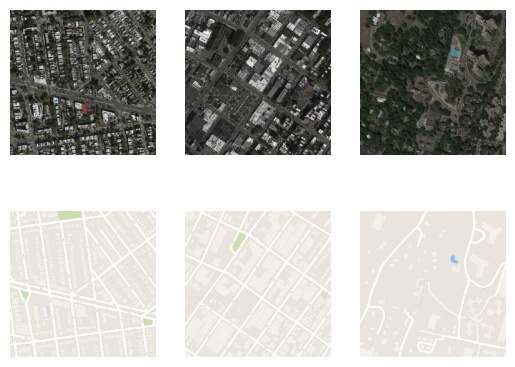

In [12]:
# loading images as arrays from folders
def load_images(path, size = (256, 512)):
    
    # empty list for storing images
    src_img, tar_img = [], []
    
    # looping though the folder and fetching all images
    for filename in os.listdir(path):
        
        # loading the image 
        loaded_img = load_img((path+filename), target_size = size)
        
        # converting image to array
        loaded_img = img_to_array(loaded_img) 
        
        # creating target and src image
        src_single_img, tar_single_img = loaded_img[:, :256], loaded_img[:, 256:]
        
        # adding the images to the lists
        src_img.append(src_single_img)
        tar_img.append(tar_single_img)
        
    return [np.asarray(src_img), np.asarray(tar_img)]
    
# loading the images in a given path
path = './maps/train/'
[src_images, tar_images] = load_images(path)
print('Loaded images shapes: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, (1+i))
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))
    
for i in range(n_samples):
    plt.subplot(2, n_samples, (1 + n_samples + i))
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
    
plt.show()

#### preprocessing data and training the model

In [13]:
# creating model instances
image_shape = src_images.shape[1:]
discriminator_model = Discriminator(image_shape)
generator_model = Generator(image_shape)
GAN_model = Pix2PixModel(generator_model, discriminator_model, image_shape)

# preprocessing function for images
def preprocess_images(data):
    
    # getting the data into two arrays
    X1, X2 = data[0], data[1]
    
    # scaling images from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# data
data = [src_images, tar_images]

# preprocessing the whole dataset
dataset = preprocess_images(data)

# training the model
start_time = datetime.now()
TrainGAN(discriminator_model, generator_model, GAN_model, dataset, n_epochs=100, n_batch=1)
end_time = datetime.now()
time_taken = end_time - start_time

print(f'Execution time: {time_taken}')   

1/1 [==============================] - 0s 380ms/step
>1, d1[0.444] d2[0.664] g[88.445]
1/1 [==============================] - 0s 23ms/step
>2, d1[0.332] d2[0.586] g[62.694]
1/1 [==============================] - 0s 24ms/step
>3, d1[0.336] d2[0.502] g[83.786]
1/1 [==============================] - 0s 19ms/step
>4, d1[0.336] d2[0.495] g[71.805]
1/1 [==============================] - 0s 21ms/step
>5, d1[0.409] d2[0.811] g[65.575]
1/1 [==============================] - 0s 20ms/step
>6, d1[0.551] d2[0.487] g[65.549]
1/1 [==============================] - 0s 19ms/step
>7, d1[0.285] d2[0.382] g[72.309]
1/1 [==============================] - 0s 20ms/step
>8, d1[0.232] d2[0.354] g[51.609]
1/1 [==============================] - 0s 21ms/step
>9, d1[0.247] d2[0.320] g[67.640]
1/1 [==============================] - 0s 21ms/step
>10, d1[0.227] d2[0.304] g[64.865]
1/1 [==============================] - 0s 21ms/step
>11, d1[0.113] d2[0.494] g[48.821]
1/1 [==============================] - 0s 19ms/step

#### After training model evaluation 

1/1 [==============================] - 0s 361ms/step


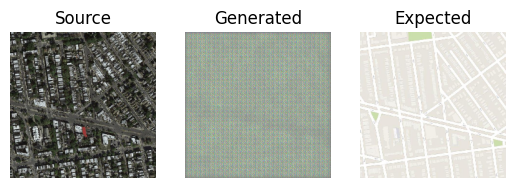

In [20]:
# loading the saved model
model = load_model('model_000010.h5')

# plotting generated images via function
def plot_images(src_img, gen_img, tar_img):
    
    # stacking image arrays 
    image_merged = np.vstack((src_img, gen_img, tar_img))
    
    # scaling from [-1,1] to [0,1]
    scaled_img = (image_merged + 1) / 2.0
    
    # plot titles
    titles = ['Source', 'Generated', 'Expected']
    
    # plotting 3 images
    for i in range(len(scaled_img)):
        
        plt.subplot(1, 3, 1+i)
        plt.axis('off')
        plt.imshow(scaled_img[i])
        plt.title(titles[i])
        
    plt.show()
    
# predicting and plotting images
[X1, X2] = dataset
idx = np.random.randint(0, len(X1), 1)
src_img, tar_img = X1[idx], X2[idx]

# generating image 
gen_img = model.predict(src_img)
plot_images(src_img, gen_img, tar_img)